In [1]:
%pip install numpy scipy scikit-learn matplotlib networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eigh

In [3]:
def load_graph(file_path):
    with open(file_path) as f:
        edges = [tuple([int(x) for x in line.strip().split(',')])[0:2] for line in f]
    
    nodes = np.unique(np.asarray(edges))

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

In [4]:
file_path = "example1.dat"
graph = load_graph(file_path)
graph

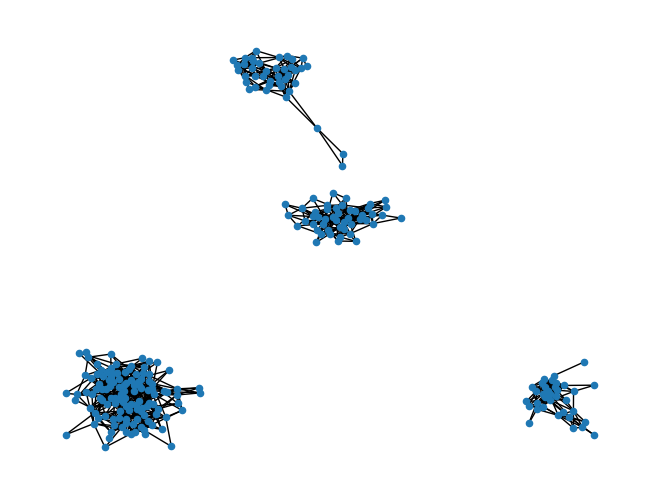

In [5]:
nx.draw(graph, node_size=20)

In [6]:
# def build_affinity_matrix(graph, num_nodes, sigma=10, weighted=False):
#     edges = nx.edges(graph)
#     A = np.zeros((num_nodes, num_nodes))
    
#     for i, j, data in graph.edges(data=True):
#         i = int(i)
#         j = int(j)
#         if i != j:
#             if weighted:
#                 weight = data.get('weight', 1)  # Get weight if it exists, otherwise default to 1
#                 A[i - 1, j - 1] = weight
#             else:
#                 A[i - 1, j - 1] = 1  # Assign 1 for unweighted edges
#             A[j - 1, i - 1] = A[i - 1, j - 1]  # Ensure symmetry
    
#     return A

In [7]:
def build_affinity_matrix(graph, num_nodes, sigma=10, weighted=False):
    edges = nx.edges(graph)
    A = np.zeros((num_nodes, num_nodes))
    if weighted:
        shortest_distance_dict = dict(nx.shortest_path_length(graph, weight="weight"))
    else:
        shortest_distance_dict = dict(nx.shortest_path_length(graph))
    for i, j in edges:
        if i != j:
            dist = int(shortest_distance_dict.get(i).get(j))
            i = int(i)
            j = int(j)
            A[i - 1, j - 1] = np.exp(-dist ** 2 / (2 * sigma ** 2))
            A[j - 1, i - 1] = A[i - 1, j - 1]  # Symmetric matrix
    return A

In [8]:
def calculate_sigma(graph,weighted = False):
    # 
    if weighted:
        shortest_distance_dict = dict(nx.shortest_path_length(graph, weight="weight"))
    else:
        shortest_distance_dict = dict(nx.shortest_path_length(graph))
    distances = []

    for i in shortest_distance_dict:
        for j, dist in shortest_distance_dict[i].items():
            if i != j:  #
                distances.append(dist)

    # sigma
    sigma_mean = np.mean(distances)  #mean
    sigma_median = np.median(distances)  
    sigma_std = np.std(distances)  

    return sigma_mean  # sigma


In [9]:
num_nodes = np.unique(np.asarray(graph)).shape[0]
num_nodes


241

In [10]:
A = build_affinity_matrix(graph, num_nodes,calculate_sigma(graph))
A

array([[0.        , 0.92123703, 0.92123703, ..., 0.        , 0.        ,
        0.        ],
       [0.92123703, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.92123703, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
def construct_diagonal(A):
    return np.diag(np.sum(A, axis=1))

In [12]:
D = construct_diagonal(A)
D

array([[6.44865922, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 7.36989625, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 8.29113329, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.84247406, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 4.60618516,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.84247406]])

In [13]:
def construct_L(A, D):
    D_inv_sqrt = np.diag(1 / np.sqrt(np.diag(D)))
    L = D_inv_sqrt @ A @ D_inv_sqrt
    return L

In [14]:
L = construct_L(A, D)
L

array([[0.        , 0.13363062, 0.12598816, ..., 0.        , 0.        ,
        0.        ],
       [0.13363062, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12598816, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [15]:
def get_eigen(L):
    eigvals, eigvecs = eigh(L)
    return eigvals, eigvecs

In [16]:
eigvals, eigvecs = get_eigen(L)
k = np.argmax(np.abs(np.ediff1d(eigvals[::-1]))) +1
print(k)
X = eigvecs[:, num_nodes - k:]
X

4


array([[ 0.        ,  0.        , -0.0867576 ,  0.        ],
       [ 0.        ,  0.        , -0.09274778,  0.        ],
       [ 0.        ,  0.        , -0.09837388,  0.        ],
       [ 0.        ,  0.        , -0.11359237,  0.        ],
       [ 0.        ,  0.        , -0.11823068,  0.        ],
       [ 0.        ,  0.        , -0.08032193,  0.        ],
       [ 0.        ,  0.        , -0.04637389,  0.        ],
       [ 0.        ,  0.        , -0.07332356,  0.        ],
       [ 0.        ,  0.        , -0.12269378,  0.        ],
       [ 0.        ,  0.        , -0.12700013,  0.        ],
       [ 0.        ,  0.        , -0.13116517,  0.        ],
       [ 0.        ,  0.        , -0.13116517,  0.        ],
       [ 0.        ,  0.        , -0.12700013,  0.        ],
       [ 0.        ,  0.        , -0.10369517,  0.        ],
       [ 0.        ,  0.        , -0.16720344,  0.        ],
       [ 0.        ,  0.        , -0.12269378,  0.        ],
       [ 0.        ,  0.

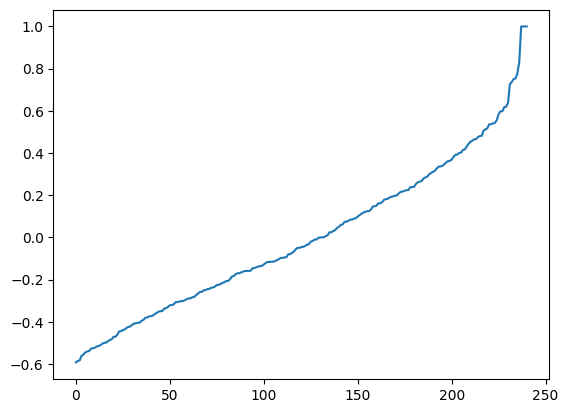

In [17]:
plt.plot(eigvals)
plt.show()

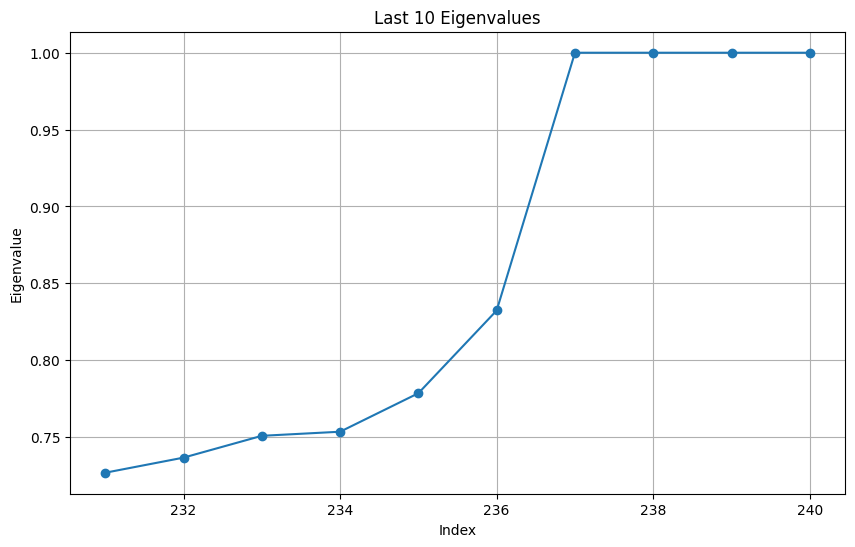

In [18]:
plt.figure(figsize=(10, 6))
last_10_indices = range(len(eigvals) - 10, len(eigvals))
last_10_eigvals = eigvals[-10:]
plt.plot(last_10_indices, last_10_eigvals, marker='o')  
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Last 10 Eigenvalues")
plt.grid(True)
plt.show()

In [19]:
def renormalize_rows(X):
    return X / np.linalg.norm(X, axis=1, keepdims=True)

In [20]:
Y = renormalize_rows(X)
Y

array([[ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  

In [21]:
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(Y)

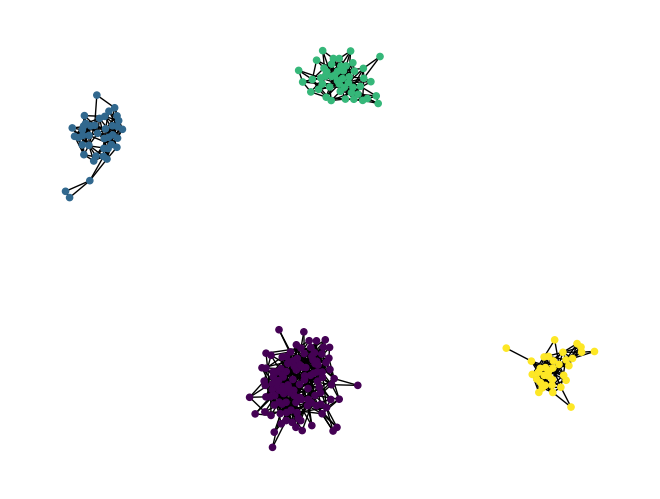

In [22]:
nx.draw(graph, node_size=20, node_color=clusters)

In [23]:
def construct_L(A, D):
    D_inv_sqrt = np.diag(1 / np.sqrt(np.diag(D)))
    L = D_inv_sqrt @ A @ D_inv_sqrt
    return L

In [24]:
A3 = np.zeros([num_nodes, num_nodes])
for i, j in nx.edges(graph):
    i = int(i)
    j = int(j)
    A3[i-1, j-1] = 1  
    A3[j-1, i-1] = 1  

In [25]:
D3 = np.diag(np.sum(A3, axis=1))

In [26]:
L3 = D3 - A3
L3

array([[ 7., -1., -1., ...,  0.,  0.,  0.],
       [-1.,  8.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  9., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  5.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.]])

In [27]:
eigvals3, eigvecs3 = eigh(L3)

In [28]:
# FV = sorted(eigvecs3[:, 1])

In [29]:
selected_vectors = eigvecs3[:, 1:4]
fv_combined = np.mean(selected_vectors, axis=1)
sorted_fv = np.sort(fv_combined)

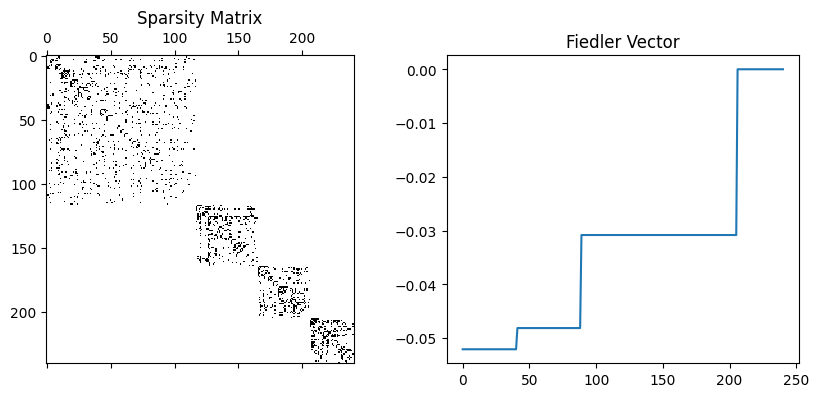

In [30]:
fig=plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.spy(A) 
plt.title('Sparsity Matrix')
plt.subplot(1,2,2)
plt.plot(np.sort(sorted_fv))
plt.title('Fiedler Vector')
plt.show()

In [32]:
file_path2 = "example2.dat"
graph2 = load_graph(file_path2)
graph2

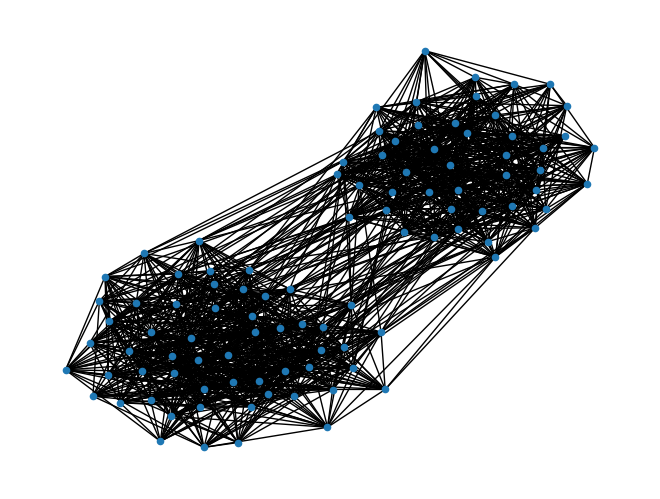

In [33]:
nx.draw(graph2, node_size=20)

In [34]:
num_nodes2 = np.unique(np.asarray(graph2)).shape[0]
num_nodes2

100

In [35]:
weight = True
A2 = build_affinity_matrix(graph2, num_nodes2, sigma=calculate_sigma(graph2,weight), weighted=True)
A2

array([[0.        , 0.86328911, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.86328911, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.86328911, 0.86328911,
        0.86328911],
       ...,
       [0.        , 0.        , 0.86328911, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.86328911, ..., 0.        , 0.        ,
        0.86328911],
       [0.        , 0.        , 0.86328911, ..., 0.        , 0.86328911,
        0.        ]])

In [36]:
D2 = construct_diagonal(A2)
D2

array([[19.85564956,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 14.67591489,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 22.44551689, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 14.67591489,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        19.85564956,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 28.48854067]])

In [37]:
L2 = construct_L(A2, D2)
L2

array([[0.        , 0.05057217, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05057217, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04756515, 0.04089304,
        0.03413944],
       ...,
       [0.        , 0.        , 0.04756515, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04089304, ..., 0.        , 0.        ,
        0.0362977 ],
       [0.        , 0.        , 0.03413944, ..., 0.        , 0.0362977 ,
        0.        ]])

In [38]:
k2 = 2
eigvals2, eigvecs2 = get_eigen(L2)
k2 = np.argmax(np.abs(np.ediff1d(eigvals2[::-1]))) +1
X2 = eigvecs2[:, num_nodes2 - k2:]
X2
k2

2

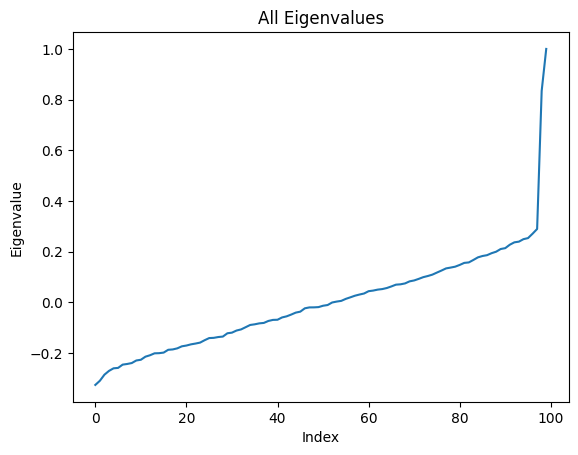

In [39]:
plt.plot(eigvals2)
plt.title("All Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.show()

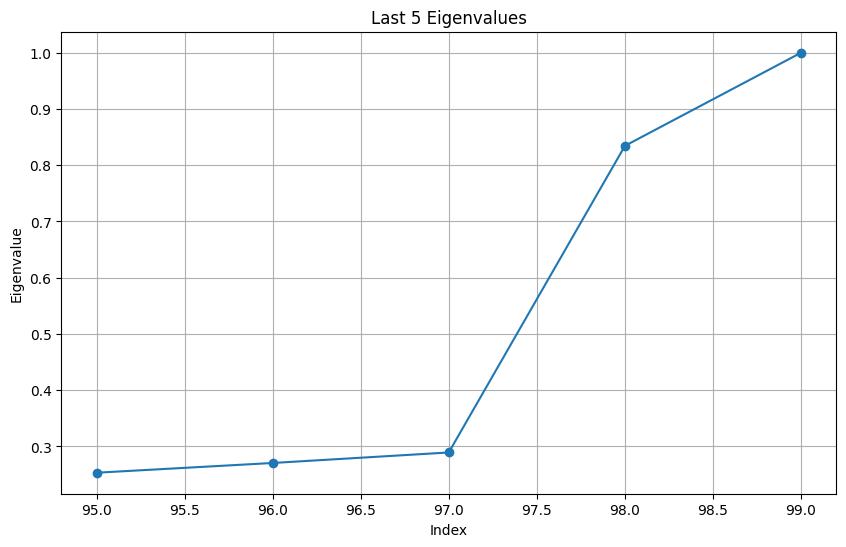

In [40]:
plt.figure(figsize=(10, 6))
last_5_indices = range(len(eigvals2) - 5, len(eigvals2))
last_5_eigvals = eigvals2[-5:]
plt.plot(last_5_indices, last_5_eigvals, marker='o')  
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Last 5 Eigenvalues")
plt.grid(True)
plt.show()

In [41]:
Y2 = renormalize_rows(X2)
Y2

array([[-0.73944909, -0.67321248],
       [-0.74722164, -0.66457492],
       [ 0.68664762, -0.72699041],
       [-0.6967126 , -0.71735037],
       [-0.73050708, -0.68290512],
       [ 0.6456588 , -0.76362603],
       [ 0.56201719, -0.82712555],
       [-0.75048282, -0.66088996],
       [-0.74411995, -0.66804603],
       [-0.74304756, -0.66923862],
       [ 0.7130389 , -0.70112448],
       [-0.72795381, -0.68562618],
       [-0.73854553, -0.6742036 ],
       [ 0.64729008, -0.76224376],
       [-0.73154122, -0.68179721],
       [ 0.64074384, -0.76775473],
       [ 0.66245286, -0.7491036 ],
       [-0.6992815 , -0.71484641],
       [-0.68483555, -0.72869765],
       [-0.70863097, -0.70557929],
       [-0.7335654 , -0.67961887],
       [ 0.64147833, -0.76714115],
       [-0.70896365, -0.70524503],
       [-0.73788155, -0.67493023],
       [-0.74281545, -0.66949624],
       [-0.720665  , -0.69328346],
       [-0.6286867 , -0.77765869],
       [ 0.73323867, -0.67997137],
       [-0.63813551,

In [42]:
kmeans2 = KMeans(n_clusters=2, random_state=1234)
clusters2 = kmeans2.fit_predict(Y2)
clusters2

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1])

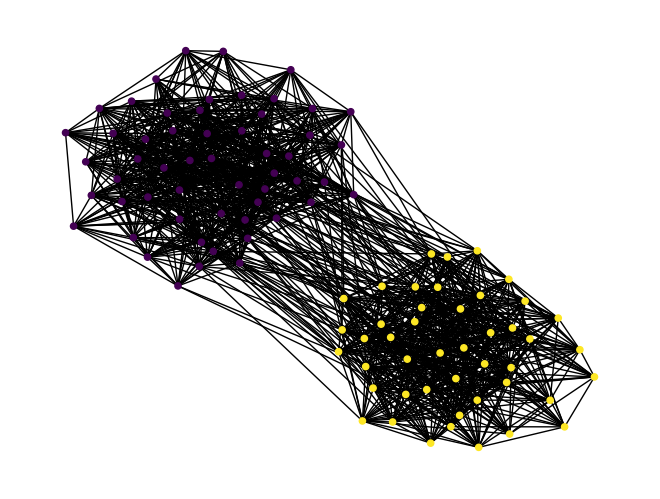

In [43]:
nx.draw(graph2, node_size=20, node_color=clusters2)

In [44]:
A4 = np.zeros([num_nodes2, num_nodes2])
for i, j in nx.edges(graph2):
    i = int(i)
    j = int(j)
    A4[i-1, j-1] = 1  
    A4[j-1, i-1] = 1  

In [45]:
D4 = np.diag(np.sum(A4, axis=1))

In [46]:
L4 = D4 - A4
L4

array([[23., -1.,  0., ...,  0.,  0.,  0.],
       [-1., 17.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 26., ..., -1., -1., -1.],
       ...,
       [ 0.,  0., -1., ..., 17.,  0.,  0.],
       [ 0.,  0., -1., ...,  0., 23., -1.],
       [ 0.,  0., -1., ...,  0., -1., 33.]])

In [47]:
eigvals4, eigvecs4 = eigh(L4)

In [48]:
selected_vectors4 = eigvecs4[:, 1:2]
fv_combined4 = np.mean(selected_vectors4, axis=1)
sorted_fv4 = np.sort(fv_combined4)

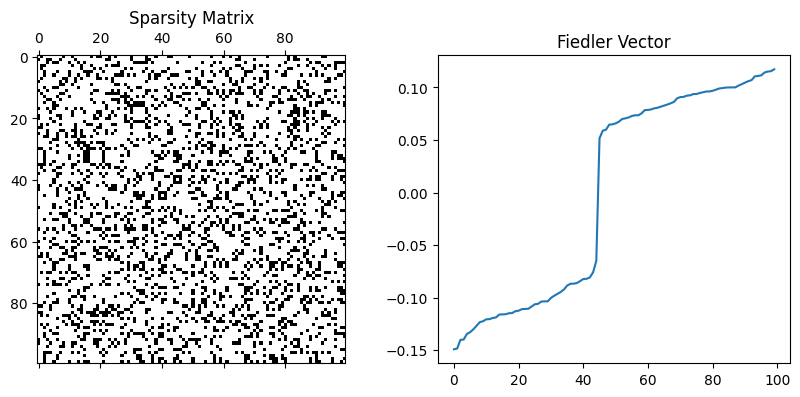

In [49]:
fig=plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.spy(A4) 
plt.title('Sparsity Matrix')
plt.subplot(1,2,2)
plt.plot(np.sort(sorted_fv4))
plt.title('Fiedler Vector')
plt.show()